# Analiza sieci komunikacji miejskiej we Wrocławiu
Natalia Iwańska, Klaudia Janicka, Wiktor Jeżowski, Michał Wiktorowski

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import folium
from typing import Literal
import webbrowser

### Inicjalizacja sieci

In [2]:
df = pd.read_csv('data/connection_graph.csv', header=0, low_memory = False)
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace = True)
df = df[df['company'].str.contains('MPK')]
diff = pd.to_datetime(df['arrival_time']) - pd.to_datetime(df['departure_time'])
df['length'] = diff.dt.seconds // 60
df.drop(columns=['departure_time', 'arrival_time'])

df.head()

C:\Users\20meh\AppData\Local\Temp\ipykernel_29472\2366264016.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  diff = pd.to_datetime(df['arrival_time']) - pd.to_datetime(df['departure_time'])
C:\Users\20meh\AppData\Local\Temp\ipykernel_29472\2366264016.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  diff = pd.to_datetime(df['arrival_time']) - pd.to_datetime(df['departure_time'])


company line departure_time arrival_time   start_stop     end_stop  \
0  MPK Autobusy    A       20:00:00     20:01:00       KRZYKI        Sowia   
1  MPK Autobusy    A       20:01:00     20:02:00        Sowia      Chłodna   
2  MPK Autobusy    A       20:02:00     20:03:00      Chłodna  Wawrzyniaka   
3  MPK Autobusy    A       20:03:00     20:05:00  Wawrzyniaka     Rymarska   
4  MPK Autobusy    A       20:05:00     20:06:00     Rymarska   RACŁAWICKA   

   start_stop_lat  start_stop_lon  end_stop_lat  end_stop_lon  length  
0       51.074884       17.006569     51.073793     17.001845       1  
1       51.073793       17.001845     51.075122     16.996671       1  
2       51.075122       16.996671     51.078074     16.998202       1  
3       51.078074       16.998202     51.079323     16.991258       2  
4       51.079323       16.991258     51.077395     16.983938       1

In [3]:
# INICJALIZACJA GRAFU

G = nx.DiGraph()

for _, row in df.iterrows():
    start = row['start_stop']
    end = row['end_stop']
    length = row['length']
    line = row['line']

    if G.has_edge(start, end):
        G[start][end]['count'] += 1
        G[start][end]['length'].append(length)
        G[start][end]['lines'].add(line)
    else:
        G.add_edge(start, end, count=1, length=[length], lines = {line})
    
for u, v, data in G.edges(data=True):
    data['length'] = max(set(data['length']), key=data['length'].count)
    data['lines'] = len(data['lines'])

# Słownik koordynatów dla każdego przystanku
coords = dict(zip(list(G.nodes), [np.array([df[df.start_stop == spot]['start_stop_lat'].mode()[0]
                                            , df[df.start_stop == spot]['start_stop_lon'].mode()[0]])
                                  for spot in list(G.nodes)]))

### Wykresy sieci

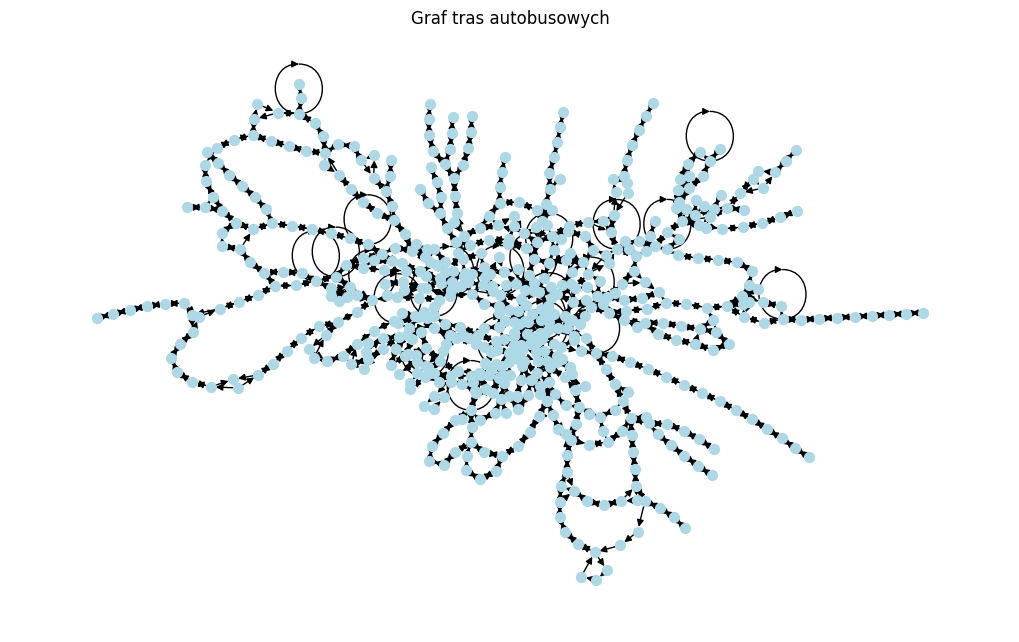

In [4]:
pos = nx.kamada_kawai_layout(G) 
edge_labels = nx.get_edge_attributes(G, 'Weight')  

plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_size=50, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Graf tras autobusowych")
plt.show()

In [5]:
m = folium.Map(location = (51.1078565, 17.04563742), zoom_start = 15)

for node, pos in coords.items():
    folium.CircleMarker(location=pos, radius=2, color='blue', fill=True, fill_color='blue').add_to(m)

for u, v, data in G.edges(data=True):
    folium.PolyLine([coords[u], coords[v]], color='black', weight=1.5, opacity=1).add_to(m)

# Zapisanie mapy do pliku HTML
filepath = "network_maps/plain_network.html"
m.save(filepath)

# # Otworzenie mapy w przeglądarce
# webbrowser.open(filepath)
m

In [6]:
def modularity_change(network = G):
    communities = list(nx.algorithms.community.girvan_newman(network))
    i = []
    modularity = []
    for element in communities:
        mod = nx.algorithms.community.modularity(network, element)
        modularity.append(mod)
        i.append(communities.index(element) + 1)
    
    return communities, i, modularity

def best_split(network = G):
    communities, i, modularity = modularity_change(network)
    best_modularity = max(modularity)
    best_index = i[modularity.index(best_modularity)]
    best_community = communities[modularity.index(best_modularity)]
    
    return best_community, best_index, best_modularity

In [7]:
def color_communities(community, G = G):
    def create_node_to_partition_mapping(partition):
        node_to_partition = {}
        for idx, cluster_nodes in enumerate(partition):
            for node in cluster_nodes:
                node_to_partition[node] = idx
        return node_to_partition

    # Słownik 1 - przydzielenie każdego przystanku do społeczności - każdy przystanek ma przypisany numer społeczności
    community_id = [create_node_to_partition_mapping(community)[n] for n in G.nodes]
    dict1 = dict(zip(coords.keys(), community_id))

    # Słownik 2 - Do każdego numeru społeczności przypisujemy kolor
    unique_community_id = list(set(community_id))
    cmap = plt.cm.get_cmap('gist_ncar')
    selected_colors = [cmap(i) for i in np.linspace(0, 1, len(unique_community_id))]
    selected_colors = ["#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in selected_colors]
    dict2 = dict(zip(unique_community_id, selected_colors))

    # Słownik 3 - każdy przystanek ma przypisany kolor odpowiadający jego społeczności
    dict3 = {key: dict2[value] for key, value in dict1.items()} 
    
    return dict3

In [8]:
girvan_newman_community, _, _ = best_split()
girvan_newman_community_colors = color_communities(girvan_newman_community)


m = folium.Map(location = (51.1078565, 17.04563742), zoom_start = 15)

for node, pos in coords.items():
    color = girvan_newman_community_colors[node]
    folium.CircleMarker(location=pos, radius=2, color=color, fill=True, fill_color=color).add_to(m)

for u, v, data in G.edges(data=True):
    folium.PolyLine([coords[u], coords[v]], color='black', weight=1.5, opacity=1).add_to(m)

# Zapisanie mapy do pliku HTML
filepath = "network_maps/girvan_newman_communities.html"
m.save(filepath)

## Otworzenie mapy w przeglądarce
# webbrowser.open(filepath)
m

C:\Users\20meh\AppData\Local\Temp\ipykernel_29472\3156615473.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_ncar')


In [9]:
louvain_community = list(nx.community.louvain_communities(G, seed = 2))
louvain_community_colors = color_communities(louvain_community)


m = folium.Map(location = (51.1078565, 17.04563742), zoom_start = 15)

for node, pos in coords.items():
    color = louvain_community_colors[node]
    folium.CircleMarker(location=pos, radius=2, color=color, fill=True, fill_color=color).add_to(m)

for u, v, data in G.edges(data=True):
    folium.PolyLine([coords[u], coords[v]], color='black', weight=1.5, opacity=1).add_to(m)

# Zapisanie mapy do pliku HTML
filepath = "network_maps/louvain_communities.html"
m.save(filepath)

## Otworzenie mapy w przeglądarce
# webbrowser.open(filepath)
m

C:\Users\20meh\AppData\Local\Temp\ipykernel_29472\3156615473.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_ncar')


### Algorytm A*

In [7]:
def time_to_int(time):
    timeSplit = time.split(":")
    timeInt = int(timeSplit[0]) * 60 + int(timeSplit[1])
    return timeInt

def time_to_str(time):
    time_str = ""
    h = (time // 60) % 24
    m = time % 60
    if h < 10:
        time_str += "0"
    time_str += str(h) + ":"
    if m < 10:
        time_str += "0"
    return time_str + str(m)

G = nx.MultiDiGraph()

for stop in set(df['start_stop']).union(set(df['end_stop'])):
    G.add_node(stop, actual_time_cost=0, actual_lines_cost=0, heuristic_cost=0, prev_node=None, prev_edge=None)

for _, row in df.iterrows():
    G.add_edge(row['start_stop'], row['end_stop'], line=row['line'], departure=time_to_int(row['departure_time']), arrival=time_to_int(row['arrival_time']), length=row['length'])




def a_star(G: nx.MultiDiGraph, coords: dict, start: str, end: str, start_time: str, priority: Literal['time', 'lines'] = 'time'):

    def get_time_cost(start: int, prev_cost: float, edge: tuple[str, str, dict]):
        start = (start + prev_cost) % 1440
        departure = edge[2]['departure'] % 1440
        arrival = edge[2]['arrival'] % 1440
        if start <= departure and start < arrival:
            return arrival - start
        return arrival - start + 1440

    def get_line_cost(departure_node: str, edge: tuple[str, str, dict]):
        if (prev_edge := G.nodes[departure_node]['prev_edge']) is None:
            return 1440
        if prev_edge[2]['line'] == edge[2]['line'] and prev_edge[2]['arrival'] == edge[2]['departure']:
            return 0
        return 1440
    
    def get_heuristic_cost(cur_node, last_node):
        cur_x, cur_y = coords[cur_node]
        last_x, last_y = coords[last_node]
        deltaX = abs(cur_x - last_x)
        deltaY = abs(cur_y - last_y)
        delta = deltaX + deltaY
        return delta / 0.011117

    def get_road():
        edges = []
        road = []
        line = None
        arrival_time = None
        departure_time = None
        last_stop = end
        stop = end
        edge = G.nodes[end]['prev_edge']
        while edge is not None:
            edges.append((edge[0], edge[1]))
            cur_line = edge[2]['line']
            cur_arrival_time = edge[2]['arrival']
            if cur_line != line or cur_arrival_time != departure_time:
                if stop is not end:
                    road.append([stop, last_stop, line, time_to_str(departure_time), time_to_str(arrival_time)])
                line = cur_line
                arrival_time = cur_arrival_time
                last_stop = stop
            departure_time = edge[2]['departure']
            stop = edge[0]
            edge = G.nodes[stop]['prev_edge']
        if stop == start:
            road.append([stop, last_stop, line, time_to_str(departure_time), time_to_str(arrival_time)])
            return list(reversed(road)), list(reversed(edges))
        else:
            return None
    
    G.nodes[start]['actual_time_cost'] = 0
    G.nodes[start]['actual_lines_cost'] = 0
    G.nodes[start]['heuristic_cost'] = 0
    G.nodes[start]['prev_node'] = None
    G.nodes[start]['prev_edge'] = None
    G.nodes[end]['prev_node'] = None
    G.nodes[end]['prev_edge'] = None

    start_time = time_to_int(start_time)

    opened = [start]
    closed = []

    if priority == 'time':
        primary_cost = 'actual_time_cost'
        secondary_cost = 'actual_lines_cost'
    else:
        primary_cost = 'actual_lines_cost'
        secondary_cost = 'actual_time_cost'

    while opened:
        node_to_check = None
        cost_primary = float('inf')
        cost_secondary = float('inf')
        for stop in opened:
            if G.nodes[stop][primary_cost] + G.nodes[stop]['heuristic_cost'] < cost_primary or \
                    (G.nodes[stop][primary_cost] + G.nodes[stop]['heuristic_cost'] == cost_primary and G.nodes[stop][secondary_cost] + G.nodes[stop]['heuristic_cost'] < cost_secondary):
                node_to_check = stop
                cost_primary = G.nodes[stop][primary_cost] + G.nodes[stop]['heuristic_cost']
                cost_secondary = G.nodes[stop][secondary_cost] + G.nodes[stop]['heuristic_cost']
        if node_to_check == end:
            opened.clear()
        else:
            opened.remove(node_to_check)
            closed.append(node_to_check)
            for next_edge in G.edges(node_to_check, data=True):
                next_node = next_edge[1]
                if priority == 'time':
                    cur_primary_cost = G.nodes[node_to_check][primary_cost] + get_time_cost(start_time, G.nodes[node_to_check][primary_cost], next_edge)
                    cur_secondary_cost = G.nodes[node_to_check][secondary_cost] + get_line_cost(node_to_check, next_edge)
                else:
                    cur_secondary_cost = G.nodes[node_to_check][primary_cost] + get_time_cost(start_time, G.nodes[node_to_check][primary_cost], next_edge)
                    cur_primary_cost = G.nodes[node_to_check][secondary_cost] + get_line_cost(node_to_check, next_edge)
                if next_node not in opened and next_node not in closed:
                    opened.append(next_node)
                    G.nodes[next_node]['heuristic_cost'] = get_heuristic_cost(next_node, end)
                    G.nodes[next_node][primary_cost] = cur_primary_cost
                    G.nodes[next_node][secondary_cost] = cur_secondary_cost
                    G.nodes[next_node]['prev_node'] = node_to_check
                    G.nodes[next_node]['prev_edge'] = next_edge
                elif G.nodes[next_node][primary_cost] > cur_primary_cost or (G.nodes[next_node][primary_cost] == cur_primary_cost and G.nodes[next_node][secondary_cost] > cur_secondary_cost):
                    G.nodes[next_node][primary_cost] = cur_primary_cost
                    G.nodes[next_node][secondary_cost] = cur_secondary_cost
                    G.nodes[next_node]['prev_node'] = node_to_check
                    G.nodes[next_node]['prev_edge'] = next_edge
                    if next_node in closed:
                        opened.append(next_node)
                        closed.remove(next_node)
    
    return get_road()




a_star(G, coords, 'Nowy Dwór', 'PL. GRUNWALDZKI', '23:00', 'time')

([['Nowy Dwór', 'Fabryczna', '106', '23:00', '23:04'],
  ['Fabryczna',
   'pl. Strzegomski (Muzeum Współczesne)',
   '107',
   '23:07',
   '23:11'],
  ['pl. Strzegomski (Muzeum Współczesne)',
   'PL. JANA PAWŁA II',
   '32',
   '23:12',
   '23:15'],
  ['PL. JANA PAWŁA II', 'Broniewskiego', '104', '23:15', '23:23'],
  ['Broniewskiego', 'PL. GRUNWALDZKI', '111', '23:26', '23:41']],
 [('Nowy Dwór', 'Nowodworska'),
  ('Nowodworska', 'Strzegomska 148'),
  ('Strzegomska 148', 'Otyńska'),
  ('Otyńska', 'Fabryczna'),
  ('Fabryczna', 'Dolnośląska Szkoła Wyższa'),
  ('Dolnośląska Szkoła Wyższa', 'Wrocławski Park Przemysłowy'),
  ('Wrocławski Park Przemysłowy', 'Śrubowa'),
  ('Śrubowa', 'pl. Strzegomski (Muzeum Współczesne)'),
  ('pl. Strzegomski (Muzeum Współczesne)', 'Młodych Techników'),
  ('Młodych Techników', 'PL. JANA PAWŁA II'),
  ('PL. JANA PAWŁA II', 'Dmowskiego'),
  ('Dmowskiego', 'Pomorska'),
  ('Pomorska', 'Dubois'),
  ('Dubois', 'Paulińska'),
  ('Paulińska', 'DWORZEC NADODRZE'),
  ('